# **01 - Noise Cancellation Benchmark**

### **Datasets**
- [VoiceBank-DEMAND](https://datashare.ed.ac.uk/handle/10283/2791)
- [DNS by Microsoft](https://github.com/microsoft/DNS-Challenge)
- [VoxConverse](https://www.kaggle.com/datasets/washingtongold/voxconverse-dataset)


### **Models to Test**
| Model                       | Framework   | Real-Time | Strengths                                                |
| --------------------------- | ----------- | --------- | -------------------------------------------------------- |
| **DeepFilterNet v3**        | PyTorch     | Yes     | Real-time, efficient, modern deep filtering              |
| **RNNoise**                 | C/C++, ONNX | Yes     | Very lightweight (used in Discord, OBS), best for speech |
| **VoiceFixer**              | PyTorch     | No      | Powerful enhancement + denoising, but slower             |
| (Bonus) **Demucs (Hybrid)** | PyTorch     | ⚠ Partial | Powerful for separation, also works for denoising        |

### **RNNoise Installation on Windows**
- [RNNoise Gitlab](https://gitlab.xiph.org/xiph/rnnoise/)
- [Install MSYS2 (for Unix-like build tools on Windows)](https://www.msys2.org/)
- Open the MSYS2 terminal (64-bit)
- Update MSYS2: ```pacman -Syu```
- Close, Reopen and run: `pacman -Su`
- Install required packages: `pacman -S git make autoconf automake libtool gcc`
- In MSYS2, in the root directory: 
```bash
    cd "path\to\root\directory"
    git clone https://gitlab.xiph.org/xiph/rnnoise.git
    cd rnnoise
    ./autogen.sh
    ./configure
    make
```
- This will automatically download the default pretrained model from the official Xiph servers and compile the rnnoise_demo binary tool
- RNNoise demo only works on RAW 16-bit PCM mono audio at 48kHz.
- [Convert .wav to .raw using FFmpeg](https://ffmpeg.org/download.html)

```bash
# FFmpeg usage:
ffmpeg -i noisy.wav -f s16le -acodec pcm_s16le -ac 1 -ar 48000 noisy.pcm
```

##### *FFmpeg Installation*
- [Go to](https://www.gyan.dev/ffmpeg/builds/)
- Choose a specific windows git master builds: Essentials or Full
- Extract the contents from Zip file
- Find `bin` folder inside
- Add it to Path in System variables in Environment Variables
- Check installation in cmd using `ffmpeg --version`

##### **Usage**
```bash
# Run these in MSYS2
ffmpeg -i noisy.wav -f s16le -acodec pcm_s16le -ac 1 -ar 48000 noisy.pcm
./examples/rnnoise_demo noisy.pcm denoised.pcm
ffmpeg -f s16le -ar 48000 -ac 1 -i denoised.pcm denoised.wav

# Run these externally
!ffmpeg -i noisy.wav -f s16le -acodec pcm_s16le -ac 1 -ar 48000 noisy.pcm
!./examples/rnnoise_demo noisy.pcm denoised.pcm
!ffmpeg -f s16le -ar 48000 -ac 1 -i denoised.pcm denoised.wav

# Now load denoised.wav in Python
import torchaudio
waveform, sr = torchaudio.load("denoised.wav")
```

### **Deepfilternet Python wheel via pip**
- Python 3.9.23 is working, latest versions aren't
- [Install Rust for Deepfilternet Developer version](https://win.rustup.rs)
- [Deepfilternet documentation](https://github.com/Rikorose/DeepFilterNet)

```bash
# DeepFilterNet v3
pip install deepfilternet

# (Optional) Demucs
pip install demucs
```

- If the PyPI package fails (pip):
```bash
# In the working directory
git clone https://github.com/Rikorose/DeepFilterNet.git
cd DeepFilterNet
pip install ./DeepFilterNet
```
- An then for import:
```bash
from df.model import Model
```


# **Imports**

In [2]:
import os
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.signal import fftconvolve
import soundfile as sf
from pathlib import Path
import random

In [3]:
# Configuration
AUDIO_PATH = "../data/aorju.wav"  
AUG_DIR = Path("../data/augmented")
AUG_DIR.mkdir(exist_ok=True)

original_name = Path(AUDIO_PATH).stem

In [4]:
# Load original audio
waveform, sample_rate = torchaudio.load(AUDIO_PATH)
waveform = waveform.mean(dim=0, keepdim=True)  # Convert to mono if stereo

In [5]:
# Utility to save audio
def save_audio(waveform, sr, name):
    full_name = f"{original_name}_{name}.wav"
    sf.write(AUG_DIR / full_name, waveform.squeeze().numpy(), sr)

# Augmentation functions
def add_white_noise(waveform, snr_db):
    rms = torch.sqrt(torch.mean(waveform ** 2))
    noise_std = rms / (10 ** (snr_db / 20))
    noise = torch.randn_like(waveform) * noise_std
    return waveform + noise

def apply_reverb(waveform, decay=0.5):
    impulse = torch.cat([torch.tensor([1.0]), torch.zeros(int(sample_rate * decay))])
    impulse += torch.randn_like(impulse) * 0.02  # some randomness
    impulse = impulse * torch.exp(-torch.linspace(0, decay, impulse.size(0)))
    reverbed = fftconvolve(waveform.squeeze().numpy(), impulse.numpy(), mode='full')[:waveform.shape[1]]
    return torch.tensor(reverbed).unsqueeze(0)

def low_pass_filter(waveform, cutoff=300):
    return F.lowpass_biquad(waveform, sample_rate=sample_rate, cutoff_freq=cutoff)

def high_pass_filter(waveform, cutoff=3000):
    return F.highpass_biquad(waveform, sample_rate=sample_rate, cutoff_freq=cutoff)

In [6]:
# Generate and save variants
variants = {}

# White noise
for db in [0, 10, 20]:
    noisy = add_white_noise(waveform, snr_db=db)
    name = f"white_noise_{db}dB"
    save_audio(noisy, sample_rate, name)
    variants[name] = noisy

# Reverb
for decay in [0.3, 0.6]:
    reverbed = apply_reverb(waveform, decay=decay)
    name = f"reverb_{int(decay*10)}"
    save_audio(reverbed, sample_rate, name)
    variants[name] = reverbed

# Filters
low = low_pass_filter(waveform, cutoff=300)
name = "lowpass_300Hz"
save_audio(low, sample_rate, name)
variants[name] = low

high = high_pass_filter(waveform, cutoff=3000)
name = "highpass_3kHz"
save_audio(high, sample_rate, name)
variants[name] = high


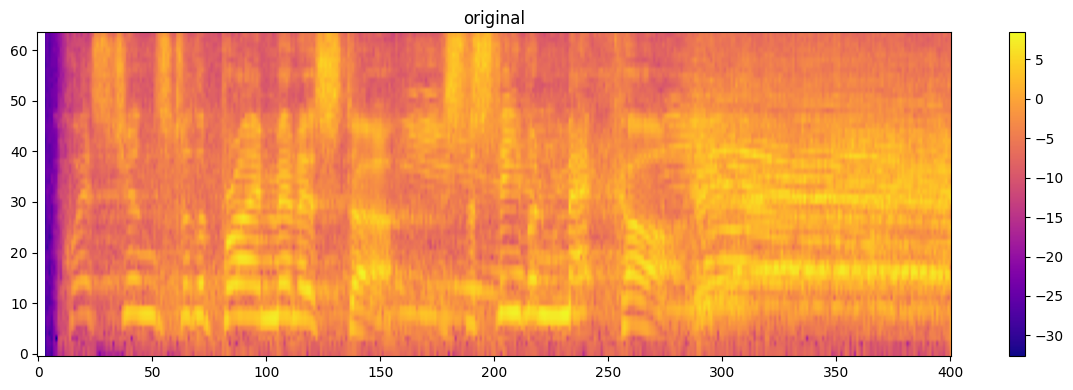

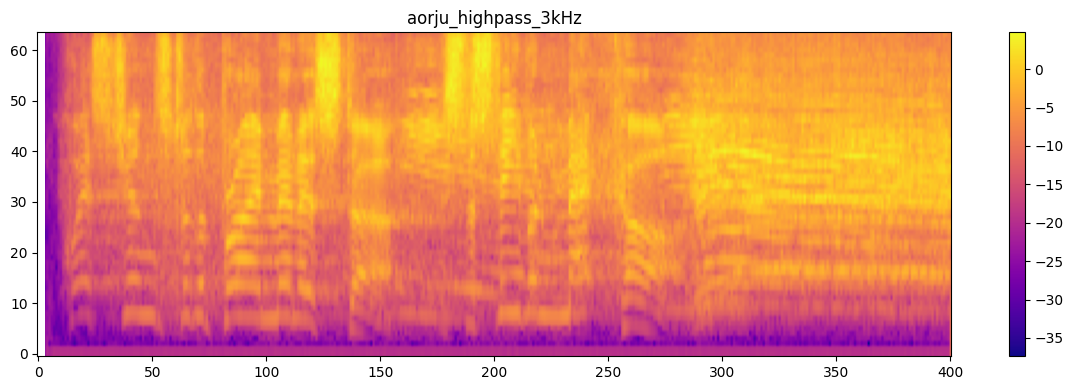

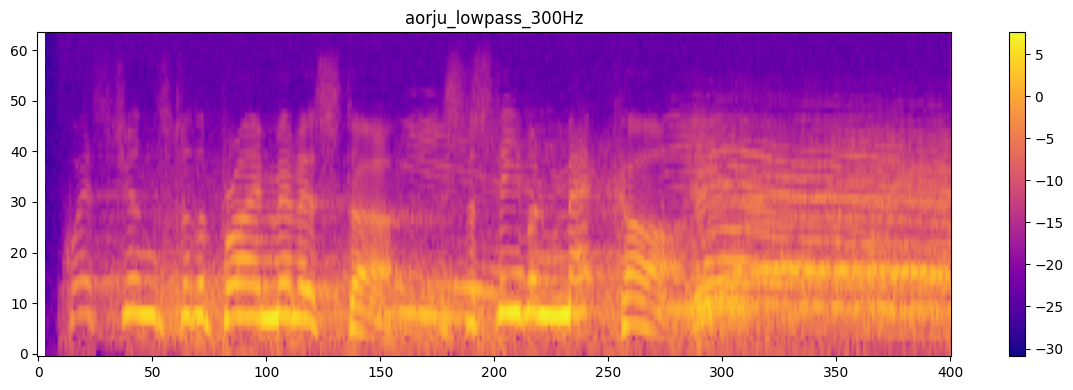

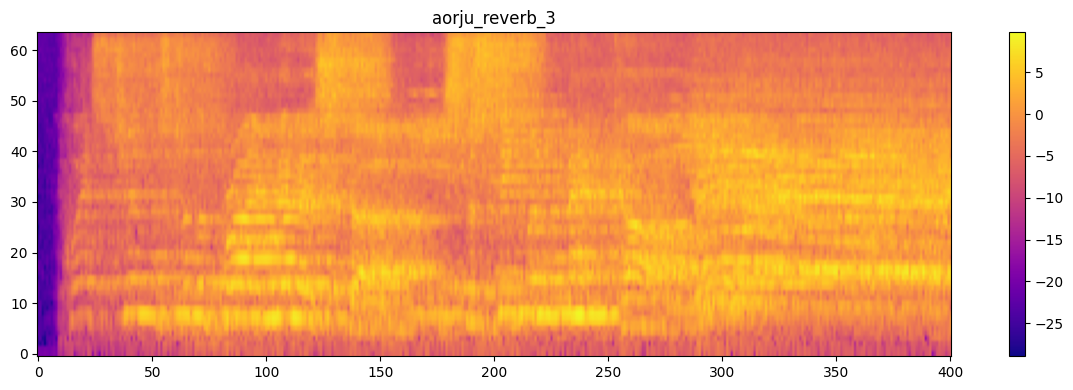

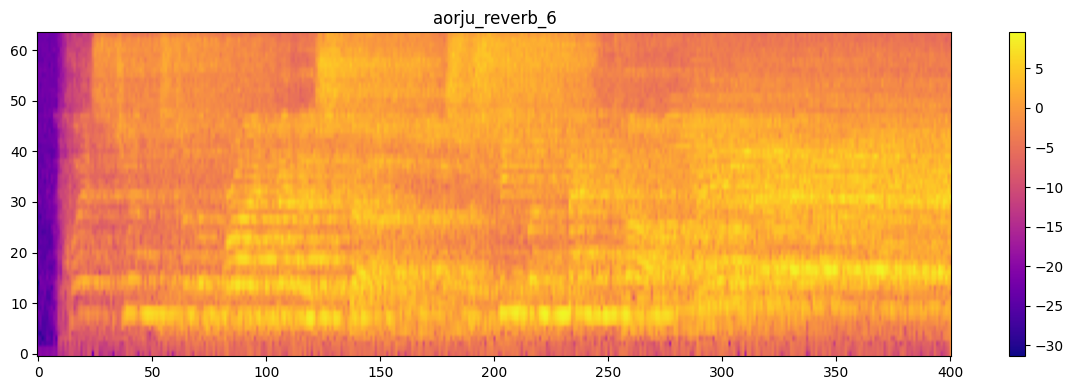

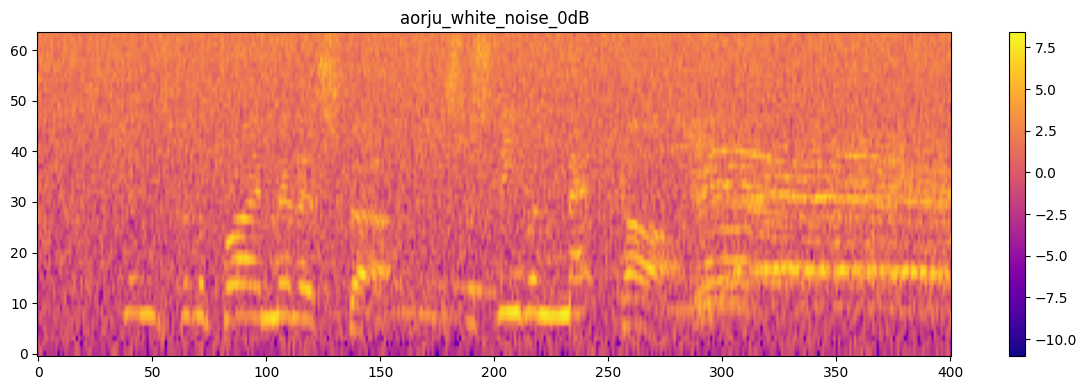

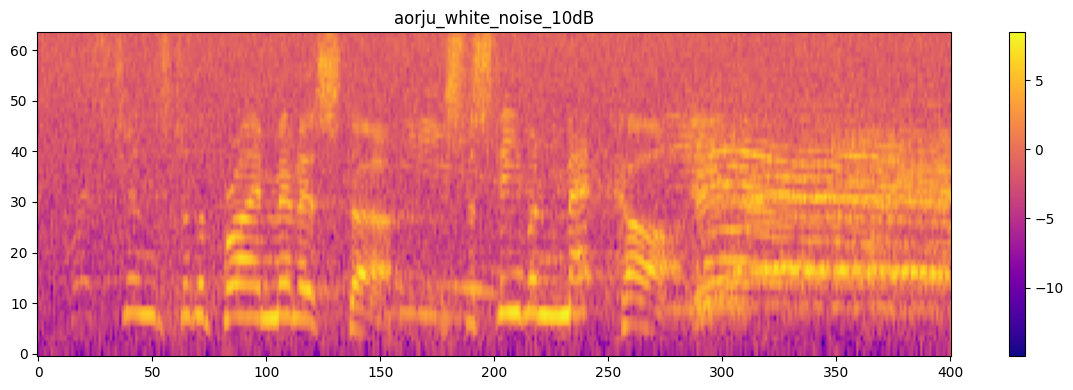

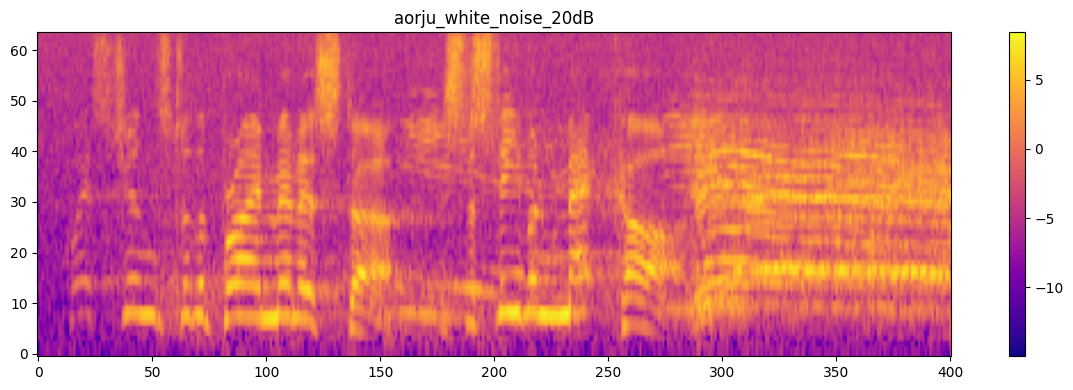

In [11]:
# mel_spec_plotter.py
import os
import gc
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from pathlib import Path

# Force OpenMP fix
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Configuration
AUDIO_PATH = "../data/aorju.wav"  
AUG_DIR = Path("../data/augmented")
VISUAL_DURATION = 5  # seconds to visualize

# Load original audio
original_wave, sample_rate = torchaudio.load(AUDIO_PATH)
original_wave = original_wave.mean(dim=0, keepdim=True)  # mono
visual_samples = int(sample_rate * VISUAL_DURATION)

# MelSpectrogram transformer
mel = T.MelSpectrogram(sample_rate=sample_rate, n_mels=64)

# Prepare variant dictionary
variants = {"original": original_wave}
for file in sorted(AUG_DIR.glob("*.wav")):
    name = file.stem
    wave, _ = torchaudio.load(file)
    wave = wave.mean(dim=0, keepdim=True)
    variants[name] = wave

# Plot all spectrograms with higher contrast and memory management
for name, wave in variants.items():
    short_wave = wave[:, :visual_samples]  # truncate
    try:
        mel_spec = mel(short_wave)
        plt.figure(figsize=(12, 4))
        plt.title(name, fontsize=12)
        plt.imshow(mel_spec.log2()[0].numpy(), aspect='auto', origin='lower', cmap='plasma')  # <-- higher contrast
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        plt.close()
        del mel_spec
        gc.collect()
    except Exception as e:
        print(f"Failed to plot {name}: {e}")


## **Testing DeepFilternet**

In [ ]:
import os
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import gc
from pathlib import Path
import soundfile as sf

# DeepFilterNet official modules
from df.enhance import enhance
import sys
from pathlib import Path
sys.path.insert(0, str(Path("D:/IIT BBS/Projects/Multisource STT/DeepFilterNet")))
from df.config import read_config


# ENV fix for Windows OpenMP issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Paths
AUG_DIR = Path("augmented")
OUTPUT_DIR = Path("data/deepfilternet_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Constants
VISUAL_DURATION = 10  # seconds
TARGET_SR = 16000  # DeepFilterNet default

# MelSpectrogram transformer
mel = T.MelSpectrogram(sample_rate=TARGET_SR, n_mels=64)
max_samples = VISUAL_DURATION * TARGET_SR

# Load DeepFilterNet config
config = read_config()

# Inference and Visualization Loop
for path in sorted(AUG_DIR.glob("*.wav")):
    try:
        name = path.stem
        out_path = OUTPUT_DIR / f"{name}_cleaned.wav"

        # DeepFilterNet inference and save output
        print(f"Enhancing {name}...")
        enhance(config, path, out_path)

        # Loading original and cleaned audio for plotting
        input_waveform, sr = torchaudio.load(path)
        cleaned_waveform, _ = torchaudio.load(out_path)

        # Ensure mono and resampled
        input_waveform = input_waveform.mean(dim=0, keepdim=True)
        cleaned_waveform = cleaned_waveform.mean(dim=0, keepdim=True)

        if sr != TARGET_SR:
            resample = T.Resample(sr, TARGET_SR)
            input_waveform = resample(input_waveform)
            cleaned_waveform = resample(cleaned_waveform)

        # Trim to first N seconds
        input_waveform = input_waveform[:, :max_samples]
        cleaned_waveform = cleaned_waveform[:, :max_samples]

        # Generate mel spectrograms
        mel_input = mel(input_waveform)
        mel_output = mel(cleaned_waveform)

        # Plot side-by-side
        plt.figure(figsize=(14, 4))
        plt.suptitle(name, fontsize=12)

        plt.subplot(1, 2, 1)
        plt.title("Input")
        plt.imshow(mel_input.log2()[0].numpy(), aspect='auto', origin='lower', cmap='plasma')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title("Cleaned")
        plt.imshow(mel_output.log2()[0].numpy(), aspect='auto', origin='lower', cmap='plasma')
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.close()

        del input_waveform, cleaned_waveform, mel_input, mel_output
        gc.collect()

    except Exception as e:
        print(f"[ERROR] {path.name}: {e}")


ImportError: cannot import name 'read_config' from 'df.config' (d:\Anaconda\envs\multi-stt-2\lib\site-packages\df\config.py)

In [18]:
import df.config
print(dir(df.config))

['DEFAULT_SECTION', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fix_clc', '_fix_df', 'allow_defaults', 'cast', 'get', 'load', 'modified', 'overwrite', 'parser', 'path', 'save', 'set', 'tostr', 'use_defaults']
